Epoch 1/50
14/14 - 3s - loss: 0.1328 - val_loss: 0.0458 - 3s/epoch - 226ms/step
Epoch 2/50
14/14 - 0s - loss: 0.1345 - val_loss: 0.0293 - 155ms/epoch - 11ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0605 - val_loss: 0.0283 - 171ms/epoch - 12ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0116 - val_loss: 0.0219 - 154ms/epoch - 11ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0095 - val_loss: 0.0060 - 162ms/epoch - 12ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0016 - val_loss: 0.0087 - 146ms/epoch - 10ms/step
Epoch 7/50
14/14 - 0s - loss: 6.6081e-04 - val_loss: 0.0070 - 139ms/epoch - 10ms/step
Epoch 8/50
14/14 - 0s - loss: 8.0579e-04 - val_loss: 0.0072 - 161ms/epoch - 12ms/step
Epoch 9/50
14/14 - 0s - loss: 7.0276e-04 - val_loss: 0.0068 - 151ms/epoch - 11ms/step
Epoch 10/50
14/14 - 0s - loss: 5.8435e-04 - val_loss: 0.0072 - 181ms/epoch - 13ms/step
Epoch 11/50
14/14 - 0s - loss: 5.2993e-04 - val_loss: 0.0069 - 174ms/epoch - 12ms/step
Epoch 12/50
14/14 - 0s - loss: 5.0386e-04 - val_loss: 0.0069 - 142ms/epoch - 1

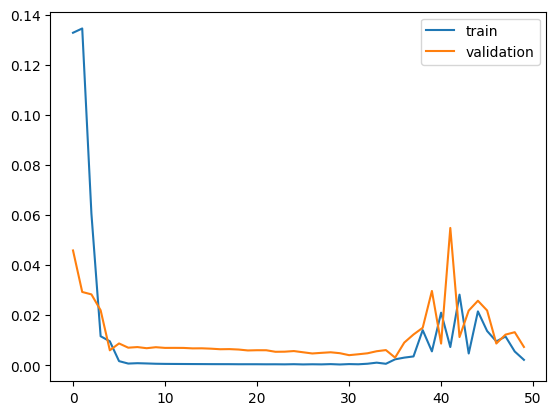

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 3, 128)            63744     
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 103105 (402.75 KB)
Trainable params: 103105 (402.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


/home/vscode/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.08540449313319927


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot
from pickle import load

# Load data
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

# Parameters
LR = 0.0001
BATCH_SIZE = 128
N_EPOCH = 50

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]


def basic_GRU(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=128, return_sequences = True, input_shape=(input_dim, feature_size)))  # 256, return_sequences = True
    # model.add(GRU(units=256, recurrent_dropout = 0.2)) #, return_sequences = True
    model.add(GRU(units=64, input_shape=(input_dim, feature_size)))
    #model.add(Dense(128))
    model.add(Dense(32))
    # model.add(Dense(32))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr=LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return model


model = basic_GRU(input_dim, output_dim, feature_size)
print(model.summary())
model.save('GRU_30to3.h5')

yhat = model.predict(X_test, verbose=0)
# print(yhat)

rmse = sqrt(mean_squared_error(y_test, yhat))
print(rmse)

In [25]:
## TRAIN DATA
def plot_traindataset_result(X_train, y_train):
    train_yhat = model.predict(X_train, verbose=0)

    y_scaler = load(open('y_scaler.pkl', 'rb'))
    train_predict_index = np.load("index_train.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_train)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Train", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Train RMSE -- ', RMSE)

    return RMSE

/tmp/ipykernel_697/3817928297.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_697/3817928297.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


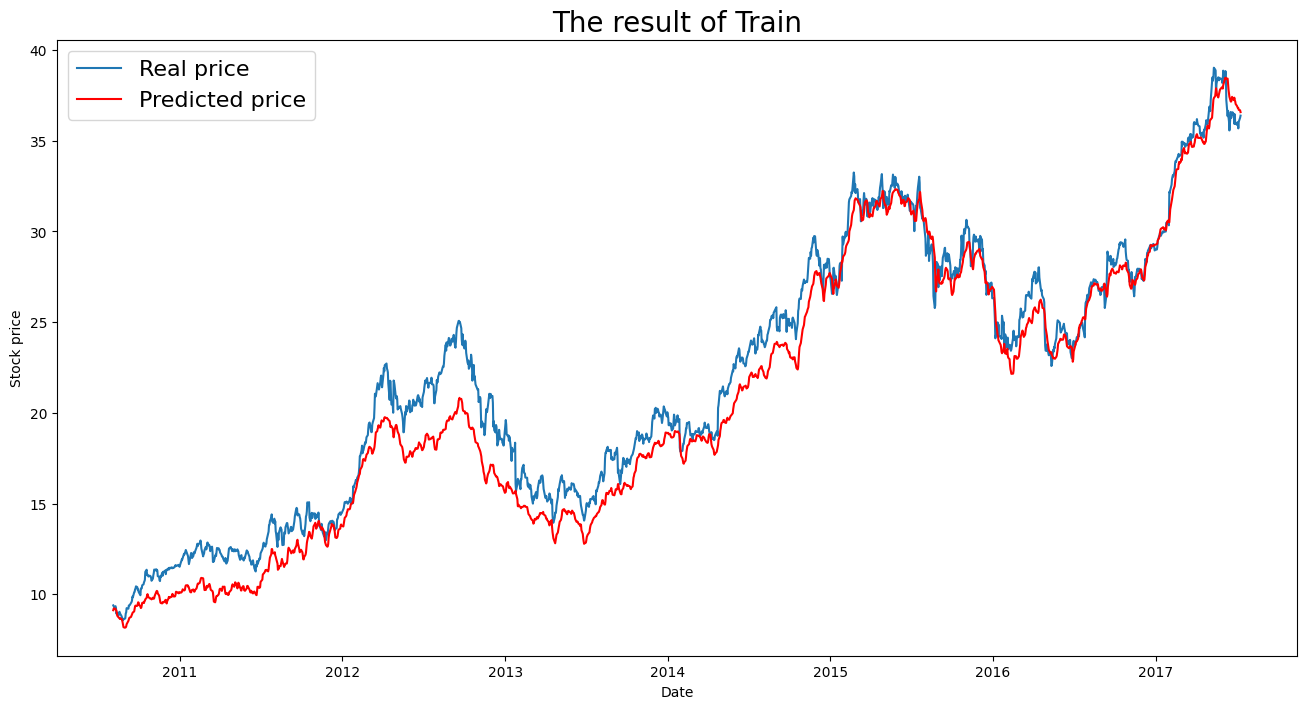

----- Train_RMSE_LSTM ----- 1.6034769519077072


/tmp/ipykernel_697/733826539.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_697/733826539.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


            predicted_price  predicted_price  predicted_price  \
2019-12-17              NaN              NaN              NaN   
2019-12-18              NaN              NaN              NaN   
2019-12-19              NaN              NaN              NaN   
2019-12-20              NaN              NaN              NaN   
2019-12-23              NaN              NaN              NaN   
2019-12-24              NaN              NaN              NaN   
2019-12-26              NaN              NaN              NaN   
2019-12-27              NaN              NaN              NaN   
2019-12-30              NaN              NaN              NaN   
2019-12-31              NaN              NaN              NaN   

            predicted_price  predicted_price  predicted_price  \
2019-12-17              NaN              NaN              NaN   
2019-12-18              NaN              NaN              NaN   
2019-12-19              NaN              NaN              NaN   
2019-12-20              

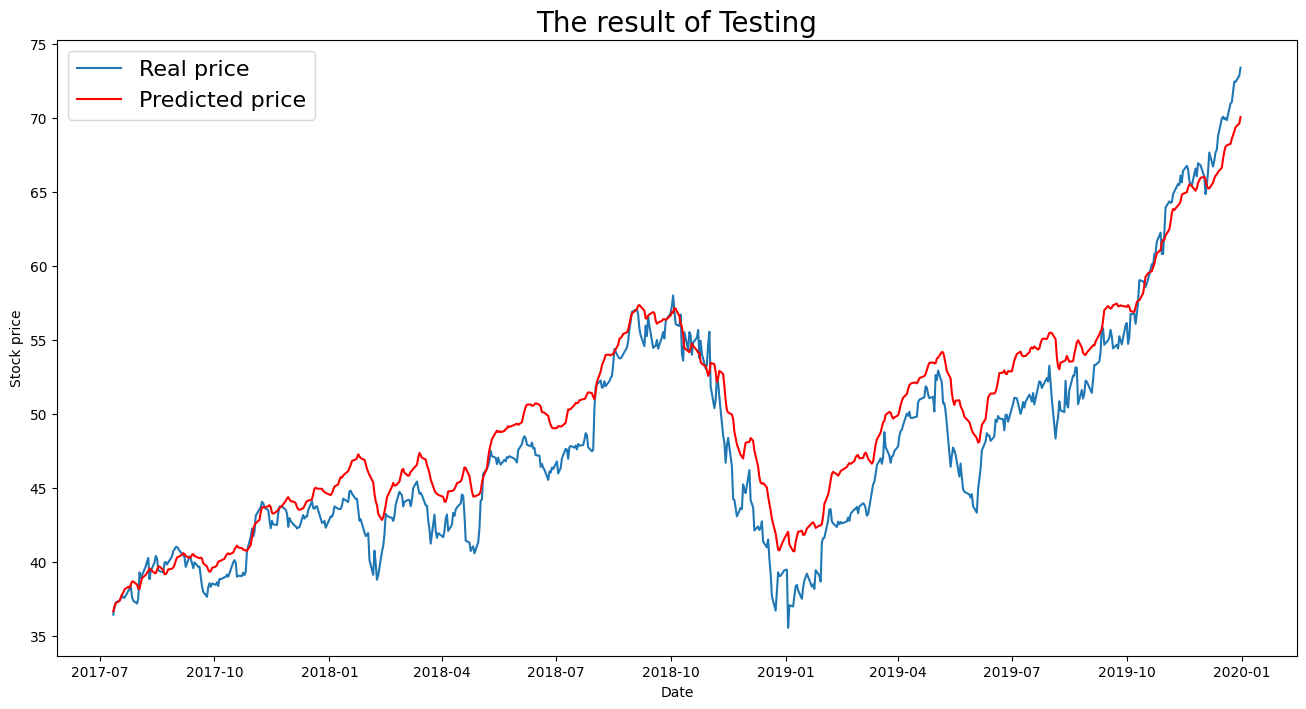

----- Test_RMSE_LSTM ----- 2.4434819761146653


/tmp/ipykernel_697/733826539.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_697/733826539.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


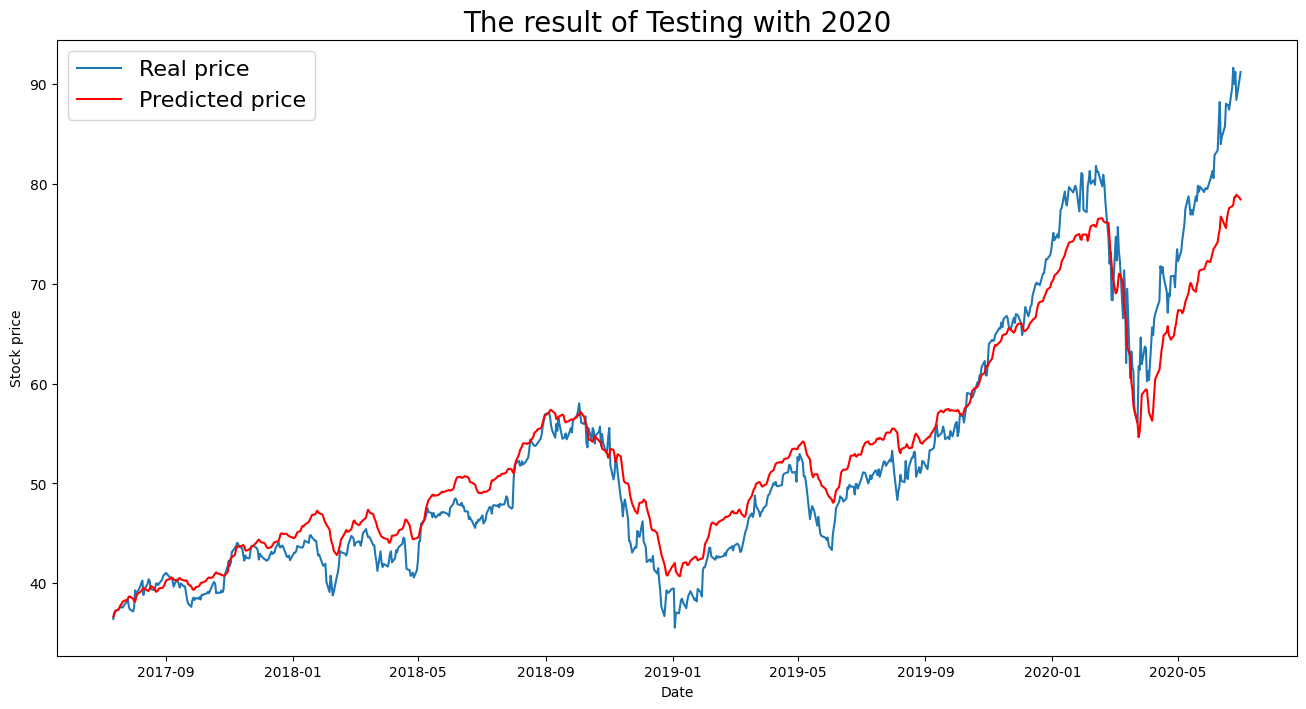

----- Test_RMSE_LSTM_with2020 ----- 3.547001371596457


/tmp/ipykernel_697/3817928297.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_697/3817928297.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


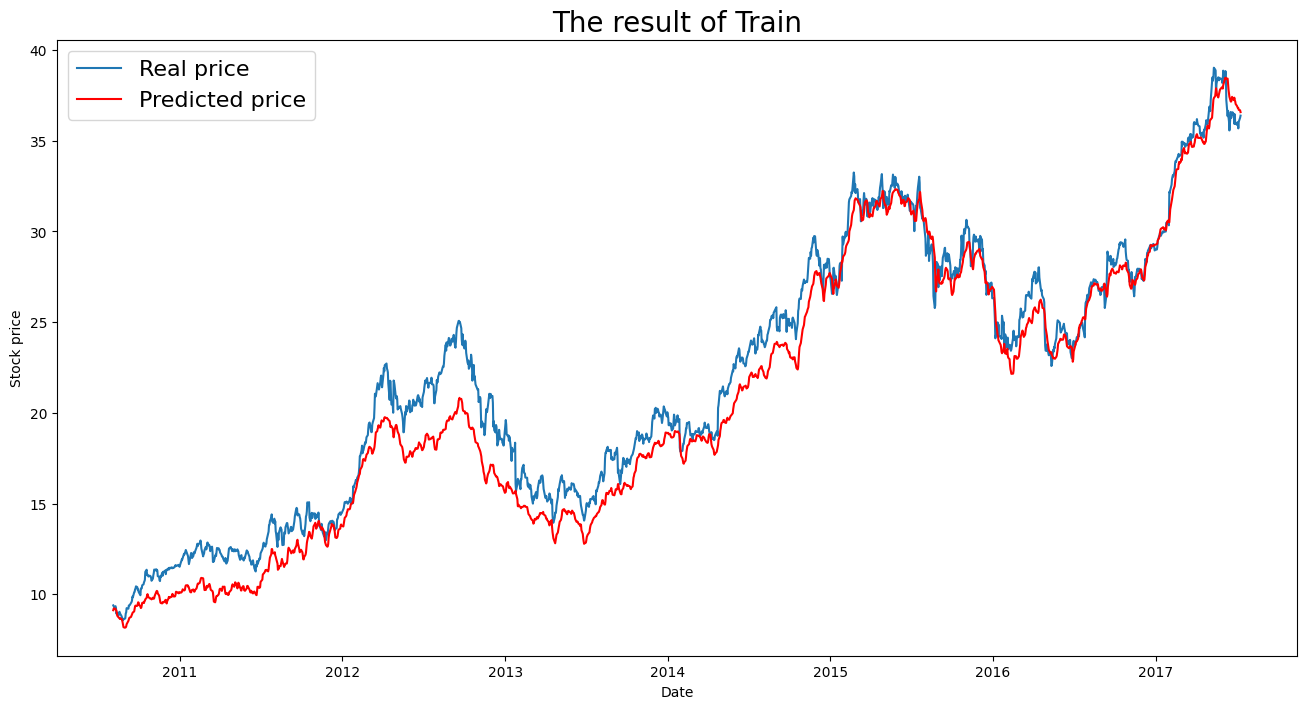

----- Train_RMSE_LSTM ----- 1.6034769519077072


/tmp/ipykernel_697/733826539.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_697/733826539.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


            predicted_price  predicted_price  predicted_price  \
2019-12-17              NaN              NaN              NaN   
2019-12-18              NaN              NaN              NaN   
2019-12-19              NaN              NaN              NaN   
2019-12-20              NaN              NaN              NaN   
2019-12-23              NaN              NaN              NaN   
2019-12-24              NaN              NaN              NaN   
2019-12-26              NaN              NaN              NaN   
2019-12-27              NaN              NaN              NaN   
2019-12-30              NaN              NaN              NaN   
2019-12-31              NaN              NaN              NaN   

            predicted_price  predicted_price  predicted_price  \
2019-12-17              NaN              NaN              NaN   
2019-12-18              NaN              NaN              NaN   
2019-12-19              NaN              NaN              NaN   
2019-12-20              

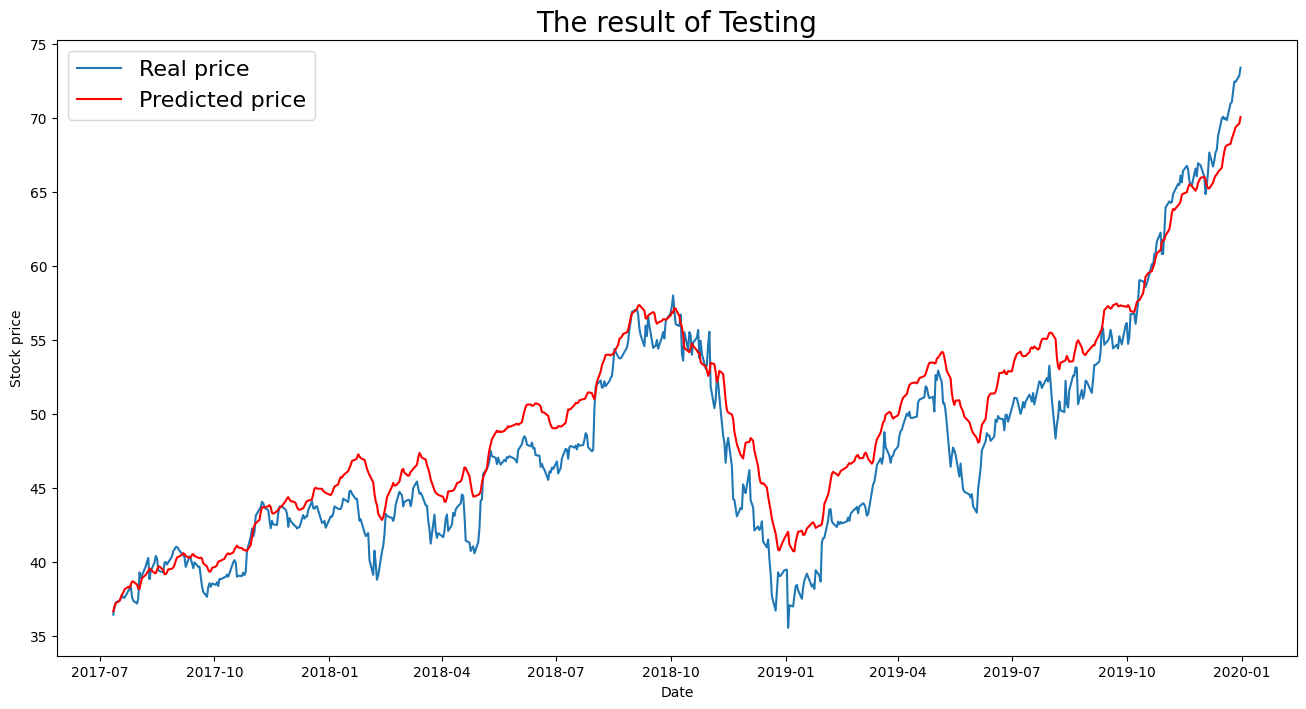

----- Test_RMSE_LSTM ----- 2.4434819761146653


/tmp/ipykernel_697/733826539.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_697/733826539.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


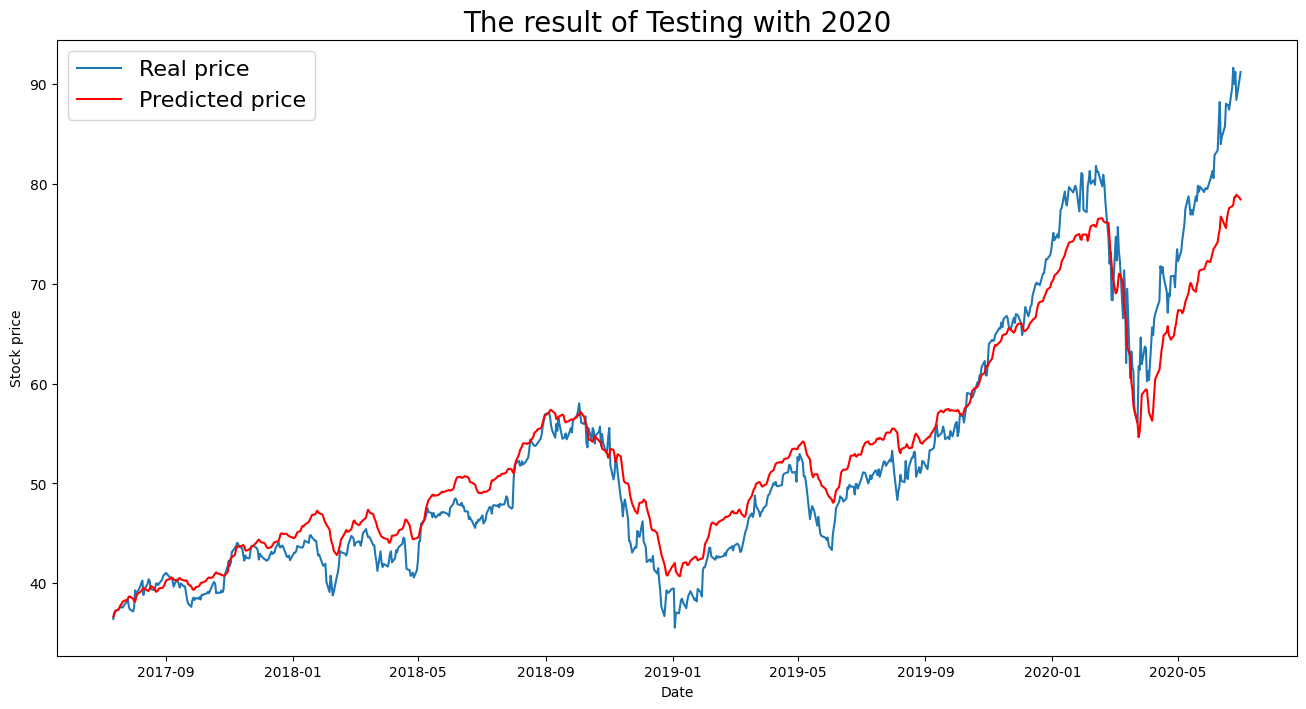

----- Test_RMSE_LSTM_with2020 ----- 3.547001371596457


In [26]:
def plot_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test, verbose=0)
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("index_test.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    Input_Before = '2020-01-01'
    predict_result = predict_result.loc[predict_result.index < Input_Before]
    real_price = real_price.loc[real_price.index < Input_Before]

    print(predict_result.tail(10))

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE -- ', RMSE)

    return RMSE

def plot_testdataset_with2020_result(X_test, y_test):


    test_yhat = model.predict(X_test, 1, verbose=0)

    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("index_test.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing with 2020", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE with 2020 -- ', RMSE)

    return RMSE

train_RMSE = plot_traindataset_result(X_train, y_train)
print("----- Train_RMSE_LSTM -----", train_RMSE)

test_RMSE = plot_testdataset_result(X_test, y_test)
print("----- Test_RMSE_LSTM -----", test_RMSE)

test_with2020_RMSE = plot_testdataset_with2020_result(X_test, y_test)
print("----- Test_RMSE_LSTM_with2020 -----", test_with2020_RMSE)

'''def plot_last3_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test[-1].reshape(1, X_test[-1].shape[0], X_test[-1].shape[1]), verbose=0)

    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test[-32:])
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    #print("----- test dataset rescaled predicted price -----", rescaled_predicted_y)
    #print("----- test dataset SHAPE rescaled predicted price -----", rescaled_predicted_y.shape)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        test_predict_index = test_predict_index[-34:]
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    ## Predicted price
    predict_result = pd.DataFrame()
    y_predict = pd.DataFrame(rescaled_predicted_y[0], columns=["predicted_price"], index=test_predict_index[-3:])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    #
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.ylim(0, 100)
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of the last set of testdata", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real[-3:]))
    #print('-- test dataset RMSE -- ', RMSE)

    return RMSE'''


train_RMSE = plot_traindataset_result(X_train, y_train)
print("----- Train_RMSE_LSTM -----", train_RMSE)

test_RMSE = plot_testdataset_result(X_test, y_test)
print("----- Test_RMSE_LSTM -----", test_RMSE)

test_with2020_RMSE = plot_testdataset_with2020_result(X_test, y_test)
print("----- Test_RMSE_LSTM_with2020 -----", test_with2020_RMSE)